In [2]:
from scripts.data import load_tables, load_blood_tests
import locals.config as cf

cache=True

blood_tests = load_blood_tests(api_key=cf.config['airtable_api_key'],base_id=cf.config['airtable_base_id'],cache=cache)
df,metadata,categories = load_tables(cf.config['tables_to_load'],api_key=cf.config['airtable_api_key'],base_id=cf.config['airtable_base_id'],cache=cache)


In [3]:
from functools import partial
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Row, Column, Button, TableColumn, DataTable, Spacer, Slider, RadioButtonGroup, Select, DatePicker, Paragraph, Div, MultiChoice, HTMLTemplateFormatter, Paragraph, Panel
from scripts.data import both_valid, data_aquisition_overlap_non_nans
import scipy.stats
import numpy
import scripts.create_app
import scripts.comparison
from datetime import datetime
from datetime import date
from scripts.data import filter_data

numpy.set_printoptions(threshold=numpy.inf)
data=df
selected_range = numpy.logical_and(data.index >= datetime.strptime('2021-03-01',"%Y-%m-%d"),data.index <= datetime.strptime('2024-01-31',"%Y-%m-%d")) 


In [25]:
def filter_data(type,data,sig):
    def gaussian(x, sig,mu):
        return numpy.exp(-numpy.power(x-mu, 2.) / (2 * numpy.power(sig, 2.)))

    def past_gaussian(x, sig,mu):
        r = numpy.exp(-numpy.power(x-mu, 2.) / (2 * numpy.power(sig, 2.)))
        return numpy.where((x-mu)<=0,r,numpy.zeros(len(x)))

    def future_gaussian(x, sig,mu):
        r = numpy.exp(-numpy.power(x-mu, 2.) / (2 * numpy.power(sig, 2.)))
        return numpy.where((x-mu)>=0,r,numpy.zeros(len(x)))

    if type == 'Gauss':
       fff = gaussian
    elif type == 'PastGauss':
       fff = past_gaussian
    elif type == 'FutureGauss':
       fff = future_gaussian

    ls = numpy.array(range(0,len(data)))
    filtr = fff(ls,sig,int(len(data)/2))

    d = numpy.ma.masked_invalid(data)
    if len(d.shape) == 1:
        result = numpy.array([numpy.ma.average(d,weights=fff(ls,sig,i),axis=0) for i in ls])
    else:
        result = numpy.array([numpy.ma.average(d,weights=fff(ls,sig,i),axis=0).filled(numpy.nan) for i in ls])
    return filtr,result

In [26]:
tt = filter_data('PastGauss',df.loc[selected_range,:].to_numpy(),2)[1]

In [27]:
a = filter_data('PastGauss',df.loc[selected_range,"Tossing & Turning"].to_numpy(),2)[1]

In [28]:
cols = list(df.columns)
X = df["Tossing & Turning"].loc[selected_range].to_numpy()
Y = df["Chocolate (only cocoa part in grams)"].loc[selected_range].to_numpy()
X_convolved = tt[:,cols.index("Tossing & Turning")]
Y_convolved = tt[:,cols.index("Chocolate (only cocoa part in grams)")]

In [19]:
print(X)
print(Y)
print(X_convolved)
print(Y_convolved)

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan 0.07  nan 0.07 0.08 0.09 0.09 0.07 0.12 0.06 0.1  0.09 0.17 0.09
 0.09 

In [20]:
d1,d2 = data_aquisition_overlap_non_nans(X_convolved,Y)
print(d1)
print(d2)
print(len(d1))
print(len(d2))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.11       0.11       0.0979471
 0.07926626 0.07349658 0.07392655 0.10999411 0.10496222 0.09994952
 0.08826114 0.09602489 0.09197764 0.08773563 0.08074736 0.08209105
 0.08220825 0.08623545 0.08771568 0.08874613 0.08935573 0.08968191
 0.08984648 0.08992681 0.

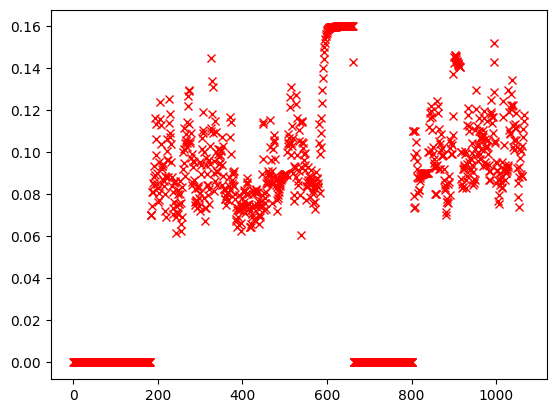

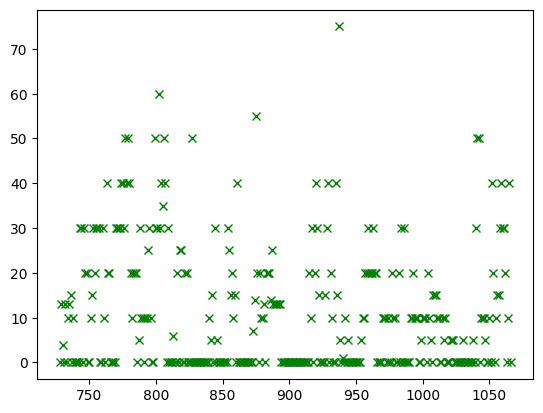

In [21]:
import pylab
pylab.figure()
pylab.plot(X_convolved,'xr')
pylab.figure()
pylab.plot(Y,'xg')

In [22]:
import scipy.stats
print(scipy.stats.linregress(d1,d2))

LinregressResult(slope=-86.64084395076273, intercept=18.061268706037065, rvalue=-0.277747752356383, pvalue=2.1042847773873782e-07, stderr=16.348183207422213, intercept_stderr=1.4882564610647837)


In [22]:
def correlation_analysis(data,metadata,source,relationships):
    val1.clear()
    val2.clear()
    rs.clear()
    pvals.clear()
    shift.clear()

    rs_v1_pr_v2.clear()
    rs_v2_pr_v1.clear()
    rs_nosh.clear()
    pvals_v1_pr_v2.clear()
    pvals_v2_pr_v1.clear()
    pvals_nosh.clear()

    acc_p.clear()
    acc_r.clear()
    acc_dir.clear()
    acc_sigma.clear()


    cols = list(data.columns)    
    print("Number of columns in the dataset: " + str(len(cols)))

    selected_range = numpy.logical_and(data.index >= datetime.strptime(ui['dt_pckr_start'].value,"%Y-%m-%d"),data.index <= datetime.strptime(ui['dt_pckr_end'].value,"%Y-%m-%d")) 

    # prepare the convolved data
    sigmas = [2,4]
    convolved = []
    for s in sigmas:
        print(s)
        convolved.append(filter_data('PastGauss',data[:,selected_range].to_numpy(),s)[1])

    for i in range(len(cols)):
        for j in range(i+1,len(cols)): 

            # make sure both variables are numeric
            if metadata['Units'].loc[cols[i]] != 'string' and metadata['Units'].loc[cols[j]] != 'string':

                    # let's calculate the correlations only for positions where both values are defined and 

                    d1,d2 = data_aquisition_overlap_non_nans(data[cols[i]][selected_range].to_numpy(),data[cols[j]][selected_range].to_numpy())
                    d1_shift1,d2_shift1 = data_aquisition_overlap_non_nans(data[cols[i]][selected_range].to_numpy()[1:],data[cols[j]][selected_range].to_numpy()[:-1])
                    d1_shift2,d2_shift2 = data_aquisition_overlap_non_nans(data[cols[i]][selected_range].to_numpy()[:-1],data[cols[j]][selected_range].to_numpy()[1:])

                    # we will not calculate correlations if variance of one of the variables within overlapping positions is zero
                    # and we will not compute correlations if there are less then 21 points of overlap between the two data vectors
                    if len(d1) > 20 and numpy.var(d1) != 0 and numpy.var(d2) != 0:
                            res1 = scipy.stats.linregress(d1,d2)
                    else:
                            res1 = None

                    if len(d1_shift1) > 20 and numpy.var(d1_shift1) != 0 and numpy.var(d2_shift1) != 0:
                            res2 = scipy.stats.linregress(d1_shift1,d2_shift1)
                    else:
                            res2 = None

                    if len(d1_shift2) > 20 and numpy.var(d1_shift2) != 0 and numpy.var(d2_shift2) != 0:
                            res3 = scipy.stats.linregress(d1_shift2,d2_shift2)
                    else:
                            res3 = None

                    res = None                       
                    if res1 != None and (res2 == None or res1.pvalue < res2.pvalue) and (res3 == None or res1.pvalue < res3.pvalue):
                       res = res1
                       shi = '=='
                    elif res2 != None and (res3 == None or res2.pvalue < res3.pvalue):  
                       res = res2
                       shi = 'Var2 -> Var1'
                    elif res3 != None:
                       res = res3
                       shi = 'Var1 -> Var2'


                    if res != None:
                       if res1 != None:
                         rs_nosh.append(res1.rvalue)
                         pvals_nosh.append(res1.pvalue)
                       else:
                         rs_nosh.append(None)
                         pvals_nosh.append(None)

                       if res2 != None:
                          rs_v2_pr_v1.append(res2.rvalue)
                          pvals_v2_pr_v1.append(res2.pvalue)
                       else:
                          rs_v2_pr_v1.append(None)
                          pvals_v2_pr_v1.append(None)

                       if res3 != None:
                          rs_v1_pr_v2.append(res3.rvalue)
                          pvals_v1_pr_v2.append(res3.pvalue)
                       else:
                          rs_v1_pr_v2.append(None)
                          pvals_v1_pr_v2.append(None)

                    if res != None:
                       shift.append(shi)
                       val1.append(cols[i])
                       val2.append(cols[j])
                       rs.append(res.rvalue)
                       pvals.append(res.pvalue)
                        
                    # now the accumulation analysis
                    best_p = 1.0
                    best_r = None
                    best_sigma = None
                    best_dir = None
                
                    if numpy.var(d1) != 0 and numpy.var(d2) != 0:
                       for s in sigmas: 
                           res = scipy.stats.linregress(convolved[s][:,i],d2)
    
                           if res.pvalue < best_p:
                                best_p = res.pvalue
                                best_r = res.rvalue
                                best_sigma = s
                                best_dir = 'Var1 -> Var2'
    
                           # then the secodn diretion
                           res = scipy.stats.linregress(d1,convolved[s][:,j])
        
                           if res.pvalue < best_p:
                                best_p = res.pvalue
                                best_r = res.rvalue
                                best_sigma = s
                                best_dir = 'Var2 -> Var1'

                    acc_p.append(best_p)
                    acc_r.append(best_r)
                    acc_dir.append(best_dir)
                    acc_sigma.append(best_sigma)

correlation_analysis(data,metadata,None,None)

NameError: name 'val1' is not defined